In [1]:
# Import all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
import os
import re
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from get_tweets import get_tweets_by_search_term, get_tweets_by_username
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
pd.set_option("display.max_columns", None)

In [2]:
# Import NLTK lexicon
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('twitter_samples')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [3]:
data = get_tweets_by_username("LibranTechie", 100)
data.head()

Unexpected parameter: language


,UserId,TweetID,tweet,location,created
0,Kimurgor,1536801672819015680,"RT @Serikalidrs: Kenyans, there are jobs in Germany for IT. Are you a Software Developer? Give m...","Perth, Western Australia",14-Jun-2022
1,Kimurgor,1536768974226345984,RT @DVCorg: 🦉📣Today we introduce the DVC extension for VS Code! Now the power of DVC is magnifi...,"Perth, Western Australia",14-Jun-2022
2,Kimurgor,1536768657136959488,@MarionChumo Bank - Bank. ✔️\nBank - Mobile? \nBank - Merchant?\nB2B? \nMpesa is unique in that ...,"Perth, Western Australia",14-Jun-2022
3,Kimurgor,1536747861534478336,A firm favourite. \nhttps://t.co/Qt2HtNT0Kh,"Perth, Western Australia",14-Jun-2022
4,Kimurgor,1536738996256387072,@its_limoo @DavisKipchirch3 Mostly first transactions from any new contact. It's pretty frustrat...,"Perth, Western Australia",14-Jun-2022


In [4]:
# Fetch the Tweets
keywords = input("Enter keywords, hashtags separated by commas: ")
keywords = list(set(keywords.split(",")))
num_tweets = int(input("Enter number of tweets to be retrieved: "))
data = get_tweets_by_search_term(keywords)

In [5]:
# Save tweets to pickle file and reload to DF - Avoid API calls
this_file_path = os.path.abspath("__file__")
BASE_DIR = os.path.dirname(this_file_path)
tweet_pickle_file = os.path.join(BASE_DIR, "tweets", "tweet_list.pkl")
data.to_pickle(tweet_pickle_file)


In [6]:
# Read pickle file
tweets_df = pd.read_pickle(tweet_pickle_file)
tweets_df.head()

,UserId,TweetId,tweet,location,created
0,Ms. Uda Sumono,1536836521168355329,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,,14-Jun-2022
1,JustColin101,1536835530213756928,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,"45 PK, Bayslide D13 Slutton",14-Jun-2022
2,Paul Mwangi,1536835220749570050,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,,14-Jun-2022
3,Champe254,1536834692875538432,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,,14-Jun-2022
4,chicharito_kim,1536833938349596673,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,,14-Jun-2022


In [7]:
# Primary exploratory analysis
print('Dataset shape:', tweets_df.shape)
print('Dataset columns:', tweets_df.columns)
tweets_df.info()

Dataset shape: (5000, 5)
Dataset columns: Index(['UserId', 'TweetId', 'tweet', 'location', 'created'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   UserId    5000 non-null   object
 1   TweetId   5000 non-null   int64 
 2   tweet     5000 non-null   object
 3   location  5000 non-null   object
 4   created   5000 non-null   object
dtypes: int64(1), object(4)
memory usage: 195.4+ KB


In [8]:
# Drop all columns except for Tweet and create a list of all words
tweets_only_df = tweets_df.drop(['UserId', 'TweetId', 'location', 'created'], axis=1)
tweets_only_df.head()

,tweet
0,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6
1,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...
2,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...
3,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...
4,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...


In [9]:
# Remove http links from tweets
def remove_http_https(text):
    return re.sub(r'http\S+', '', text)

tweets_only_df['link_removed'] = tweets_only_df['tweet'].apply(lambda x: remove_http_https(x))
tweets_only_df.head()

,tweet,link_removed
0,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6
1,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...
2,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...
3,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...
4,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...


In [10]:
# Remove punctuations
#string.punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

tweets_only_df['tweet_punct'] = tweets_only_df['tweet'].apply(lambda x: remove_punct(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct
0,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,xeiphi I LOVE this as an AU idea Rarity has always been my fave of the Mane
1,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,UlsterArtist Glenlyon olliejacq simoncoveney columeastwood MarosSefcovic Funny the UDA and LVF m...
2,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,WilliamsRuto Conflict of interest in leadership What is that really mean in a reality Why cant W...
3,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,migosibrian Ruto will not be losing anything this August Mzee wa kuzimia anafaa kujipanga \nWill...
4,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,EAtemba citizentvkenya WaihigaMwaura Those that called her out the first time cleared her in sen...


In [11]:
# Tokenize the tweets
def tokenize(text):
    text = re.split('\W+', text)
    return text

tweets_only_df['tweet_tokenized'] = tweets_only_df['tweet_punct'].apply(lambda x: tokenize(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct,tweet_tokenized
0,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,xeiphi I LOVE this as an AU idea Rarity has always been my fave of the Mane,"[xeiphi, I, LOVE, this, as, an, AU, idea, Rarity, has, always, been, my, fave, of, the, Mane, ]"
1,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,UlsterArtist Glenlyon olliejacq simoncoveney columeastwood MarosSefcovic Funny the UDA and LVF m...,"[UlsterArtist, Glenlyon, olliejacq, simoncoveney, columeastwood, MarosSefcovic, Funny, the, UDA,..."
2,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,WilliamsRuto Conflict of interest in leadership What is that really mean in a reality Why cant W...,"[WilliamsRuto, Conflict, of, interest, in, leadership, What, is, that, really, mean, in, a, real..."
3,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,migosibrian Ruto will not be losing anything this August Mzee wa kuzimia anafaa kujipanga \nWill...,"[migosibrian, Ruto, will, not, be, losing, anything, this, August, Mzee, wa, kuzimia, anafaa, ku..."
4,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,EAtemba citizentvkenya WaihigaMwaura Those that called her out the first time cleared her in sen...,"[EAtemba, citizentvkenya, WaihigaMwaura, Those, that, called, her, out, the, first, time, cleare..."


In [12]:
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

tweets_only_df['tweet_nonstop'] = tweets_only_df['tweet_tokenized'].apply(lambda x: remove_stopwords(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct,tweet_tokenized,tweet_nonstop
0,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,xeiphi I LOVE this as an AU idea Rarity has always been my fave of the Mane,"[xeiphi, I, LOVE, this, as, an, AU, idea, Rarity, has, always, been, my, fave, of, the, Mane, ]","[xeiphi, I, LOVE, AU, idea, Rarity, always, fave, Mane, ]"
1,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,UlsterArtist Glenlyon olliejacq simoncoveney columeastwood MarosSefcovic Funny the UDA and LVF m...,"[UlsterArtist, Glenlyon, olliejacq, simoncoveney, columeastwood, MarosSefcovic, Funny, the, UDA,...","[UlsterArtist, Glenlyon, olliejacq, simoncoveney, columeastwood, MarosSefcovic, Funny, UDA, LVF,..."
2,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,WilliamsRuto Conflict of interest in leadership What is that really mean in a reality Why cant W...,"[WilliamsRuto, Conflict, of, interest, in, leadership, What, is, that, really, mean, in, a, real...","[WilliamsRuto, Conflict, interest, leadership, What, really, mean, reality, Why, cant, WSR, call..."
3,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,migosibrian Ruto will not be losing anything this August Mzee wa kuzimia anafaa kujipanga \nWill...,"[migosibrian, Ruto, will, not, be, losing, anything, this, August, Mzee, wa, kuzimia, anafaa, ku...","[migosibrian, Ruto, losing, anything, August, Mzee, wa, kuzimia, anafaa, kujipanga, WilliamsRuto..."
4,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,EAtemba citizentvkenya WaihigaMwaura Those that called her out the first time cleared her in sen...,"[EAtemba, citizentvkenya, WaihigaMwaura, Those, that, called, her, out, the, first, time, cleare...","[EAtemba, citizentvkenya, WaihigaMwaura, Those, called, first, time, cleared, senate, UDA, wante..."


In [13]:
# Stemming and lemmatization
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

tweets_only_df['tweet_stemmed'] = tweets_only_df['tweet_nonstop'].apply(lambda x: stemming(x))

wn = nltk.WordNetLemmatizer()
def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text
tweets_only_df['tweet_lemmatized'] = tweets_only_df['tweet_stemmed'].apply(lambda x: lemmatizer(x))
tweets_only_df.head()

,tweet,link_removed,tweet_punct,tweet_tokenized,tweet_nonstop,tweet_stemmed,tweet_lemmatized
0,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,xeiphi I LOVE this as an AU idea Rarity has always been my fave of the Mane,"[xeiphi, I, LOVE, this, as, an, AU, idea, Rarity, has, always, been, my, fave, of, the, Mane, ]","[xeiphi, I, LOVE, AU, idea, Rarity, always, fave, Mane, ]","[xeiphi, i, love, au, idea, rariti, alway, fave, mane, ]","[xeiphi, i, love, au, idea, rariti, alway, fave, mane, ]"
1,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,UlsterArtist Glenlyon olliejacq simoncoveney columeastwood MarosSefcovic Funny the UDA and LVF m...,"[UlsterArtist, Glenlyon, olliejacq, simoncoveney, columeastwood, MarosSefcovic, Funny, the, UDA,...","[UlsterArtist, Glenlyon, olliejacq, simoncoveney, columeastwood, MarosSefcovic, Funny, UDA, LVF,...","[ulsterartist, glenlyon, olliejacq, simoncoveney, columeastwood, marossefcov, funni, uda, lvf, m...","[ulsterartist, glenlyon, olliejacq, simoncoveney, columeastwood, marossefcov, funni, uda, lvf, m..."
2,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,WilliamsRuto Conflict of interest in leadership What is that really mean in a reality Why cant W...,"[WilliamsRuto, Conflict, of, interest, in, leadership, What, is, that, really, mean, in, a, real...","[WilliamsRuto, Conflict, interest, leadership, What, really, mean, reality, Why, cant, WSR, call...","[williamsruto, conflict, interest, leadership, what, realli, mean, realiti, whi, cant, wsr, call...","[williamsruto, conflict, interest, leadership, what, realli, mean, realiti, whi, cant, wsr, call..."
3,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,migosibrian Ruto will not be losing anything this August Mzee wa kuzimia anafaa kujipanga \nWill...,"[migosibrian, Ruto, will, not, be, losing, anything, this, August, Mzee, wa, kuzimia, anafaa, ku...","[migosibrian, Ruto, losing, anything, August, Mzee, wa, kuzimia, anafaa, kujipanga, WilliamsRuto...","[migosibrian, ruto, lose, anyth, august, mzee, wa, kuzimia, anafaa, kujipanga, williamsruto, uda]","[migosibrian, ruto, lose, anyth, august, mzee, wa, kuzimia, anafaa, kujipanga, williamsruto, uda]"
4,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,EAtemba citizentvkenya WaihigaMwaura Those that called her out the first time cleared her in sen...,"[EAtemba, citizentvkenya, WaihigaMwaura, Those, that, called, her, out, the, first, time, cleare...","[EAtemba, citizentvkenya, WaihigaMwaura, Those, called, first, time, cleared, senate, UDA, wante...","[eatemba, citizentvkenya, waihigamwaura, those, call, first, time, clear, senat, uda, want, oust...","[eatemba, citizentvkenya, waihigamwaura, those, call, first, time, clear, senat, uda, want, oust..."


(-0.5, 399.5, 199.5, -0.5)

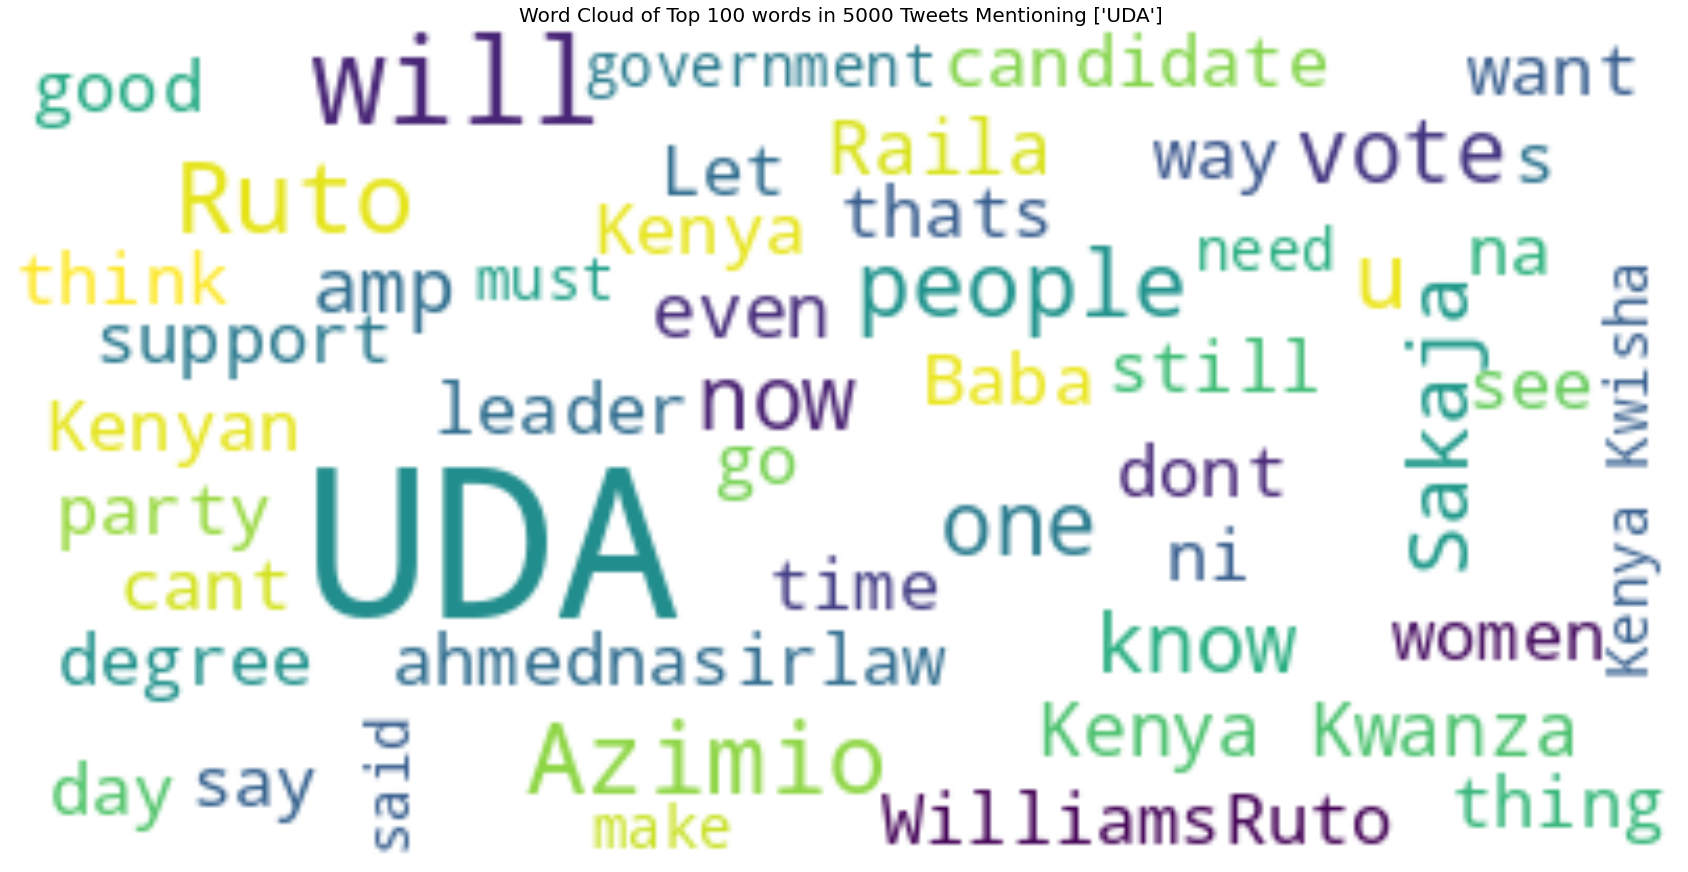

In [14]:
all_final_tweets = ' '.join(word for word in tweets_only_df['tweet_punct'])
fig, ax = plt.subplots(figsize=(30,30))
wordcloud_all_tweets = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(all_final_tweets)
ax.imshow(wordcloud_all_tweets, interpolation='bilinear')
ax.set_title(f'Word Cloud of Top 100 words in 5000 Tweets Mentioning {keywords} ', fontsize=20)
ax.axis("off")

In [15]:
# Subjectivity of the tweets using TextBlob
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

tweets_df['subjectivity'] = tweets_df['tweet'].apply(get_subjectivity)
tweets_df['polarity'] = tweets_df['tweet'].apply(get_polarity)
tweets_df.head(10)

,UserId,TweetId,tweet,location,created,subjectivity,polarity
0,Ms. Uda Sumono,1536836521168355329,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,,14-Jun-2022,0.600000,0.625000
1,JustColin101,1536835530213756928,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,"45 PK, Bayslide D13 Slutton",14-Jun-2022,0.472222,0.098611
2,Paul Mwangi,1536835220749570050,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,,14-Jun-2022,0.510417,-0.031250
3,Champe254,1536834692875538432,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,,14-Jun-2022,0.000000,0.000000
4,chicharito_kim,1536833938349596673,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,,14-Jun-2022,0.333333,0.250000
5,Alone mast.,1536833665359020033,@drsajjadkahn Haha bs pa carpet uda yam rn\nBjli nashta.\n\nWeather is something I'm really conc...,Pakistan,14-Jun-2022,0.400000,0.066667
6,kevin oyare,1536832513812873216,@RodgersKipembe When hon Raila was fighting for this nation all of Uda sycophants were being pum...,,14-Jun-2022,0.000000,0.000000
7,Joni Wacira,1536832407738925056,@hellenjeriKe Do you service UDA politicians ?,"Nairobi, Kenya",14-Jun-2022,0.000000,0.000000
8,Simon Muriithi,1536831795609706497,God is punishing Ruto and UDA in Nairobi gubernatorial race.They sacrificed Bishop Margret Wanji...,,14-Jun-2022,0.000000,0.000000
9,Atemba,1536831624645681155,@kim_chicharo @citizentvkenya @WaihigaMwaura Rem its ODM that 1st pointed a finger.But Ruto vehe...,"Nairobi, Kenya",14-Jun-2022,0.250000,0.250000


In [16]:
# Compute negative, neutral, positive analysis of the tweets
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score== 0:
        return 'Neutral'
    else:
        return 'Positive'

tweets_df['analysis'] = tweets_df['polarity'].apply(get_analysis)
tweets_df.head(10)

,UserId,TweetId,tweet,location,created,subjectivity,polarity,analysis
0,Ms. Uda Sumono,1536836521168355329,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,,14-Jun-2022,0.600000,0.625000,Positive
1,JustColin101,1536835530213756928,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,"45 PK, Bayslide D13 Slutton",14-Jun-2022,0.472222,0.098611,Positive
2,Paul Mwangi,1536835220749570050,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,,14-Jun-2022,0.510417,-0.031250,Negative
3,Champe254,1536834692875538432,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,,14-Jun-2022,0.000000,0.000000,Neutral
4,chicharito_kim,1536833938349596673,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,,14-Jun-2022,0.333333,0.250000,Positive
5,Alone mast.,1536833665359020033,@drsajjadkahn Haha bs pa carpet uda yam rn\nBjli nashta.\n\nWeather is something I'm really conc...,Pakistan,14-Jun-2022,0.400000,0.066667,Positive
6,kevin oyare,1536832513812873216,@RodgersKipembe When hon Raila was fighting for this nation all of Uda sycophants were being pum...,,14-Jun-2022,0.000000,0.000000,Neutral
7,Joni Wacira,1536832407738925056,@hellenjeriKe Do you service UDA politicians ?,"Nairobi, Kenya",14-Jun-2022,0.000000,0.000000,Neutral
8,Simon Muriithi,1536831795609706497,God is punishing Ruto and UDA in Nairobi gubernatorial race.They sacrificed Bishop Margret Wanji...,,14-Jun-2022,0.000000,0.000000,Neutral
9,Atemba,1536831624645681155,@kim_chicharo @citizentvkenya @WaihigaMwaura Rem its ODM that 1st pointed a finger.But Ruto vehe...,"Nairobi, Kenya",14-Jun-2022,0.250000,0.250000,Positive


In [17]:
def analyse_subjectivity(score):
    if score < 0.5:
        return 'Objective'
    else:
        return 'Subjective'

tweets_df['subjectivity_analysis'] = tweets_df['subjectivity'].apply(analyse_subjectivity)
tweets_df.head(10)

,UserId,TweetId,tweet,location,created,subjectivity,polarity,analysis,subjectivity_analysis
0,Ms. Uda Sumono,1536836521168355329,@xeiphi I LOVE this as an AU idea! Rarity has always been my fave of the Mane 6,,14-Jun-2022,0.600000,0.625000,Positive,Subjective
1,JustColin101,1536835530213756928,@UlsterArtist @Glenlyon17 @olliejacq @simoncoveney @columeastwood @MarosSefcovic Funny the UDA a...,"45 PK, Bayslide D13 Slutton",14-Jun-2022,0.472222,0.098611,Positive,Objective
2,Paul Mwangi,1536835220749570050,@WilliamsRuto Conflict of interest in leadership... What is that really mean in a reality? Why c...,,14-Jun-2022,0.510417,-0.031250,Negative,Subjective
3,Champe254,1536834692875538432,@migosi_brian Ruto will not be losing anything this August. Mzee wa kuzimia anafaa kujipanga \n@...,,14-Jun-2022,0.000000,0.000000,Neutral,Objective
4,chicharito_kim,1536833938349596673,@E_Atemba @citizentvkenya @WaihigaMwaura Those that called her out the first time cleared her in...,,14-Jun-2022,0.333333,0.250000,Positive,Objective
5,Alone mast.,1536833665359020033,@drsajjadkahn Haha bs pa carpet uda yam rn\nBjli nashta.\n\nWeather is something I'm really conc...,Pakistan,14-Jun-2022,0.400000,0.066667,Positive,Objective
6,kevin oyare,1536832513812873216,@RodgersKipembe When hon Raila was fighting for this nation all of Uda sycophants were being pum...,,14-Jun-2022,0.000000,0.000000,Neutral,Objective
7,Joni Wacira,1536832407738925056,@hellenjeriKe Do you service UDA politicians ?,"Nairobi, Kenya",14-Jun-2022,0.000000,0.000000,Neutral,Objective
8,Simon Muriithi,1536831795609706497,God is punishing Ruto and UDA in Nairobi gubernatorial race.They sacrificed Bishop Margret Wanji...,,14-Jun-2022,0.000000,0.000000,Neutral,Objective
9,Atemba,1536831624645681155,@kim_chicharo @citizentvkenya @WaihigaMwaura Rem its ODM that 1st pointed a finger.But Ruto vehe...,"Nairobi, Kenya",14-Jun-2022,0.250000,0.250000,Positive,Objective


In [18]:
# Compute the number of positive, negative and neutral tweets
tweets_df['analysis'].value_counts()

Neutral     2025
Positive    1833
Negative    1142
Name: analysis, dtype: int64

Text(0.5, 1.0, "Histogram of the Polarity of the Tweets - ['UDA']")

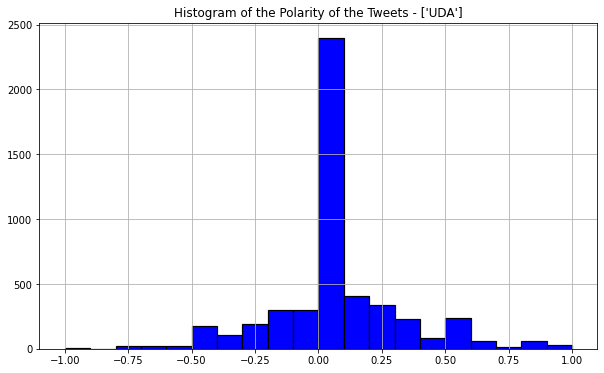

In [19]:
# Plot histogram of the polarity of the tweets
ax0 = tweets_df['polarity'].hist(bins=20, color='blue', edgecolor='black', linewidth=1.2, figsize=(10, 6))
ax0.set_title(f'Histogram of the Polarity of the Tweets - {keywords}', fontsize=12)

Text(0.5, 1.0, "Analysis of Tweets by Search Term: ['UDA']")

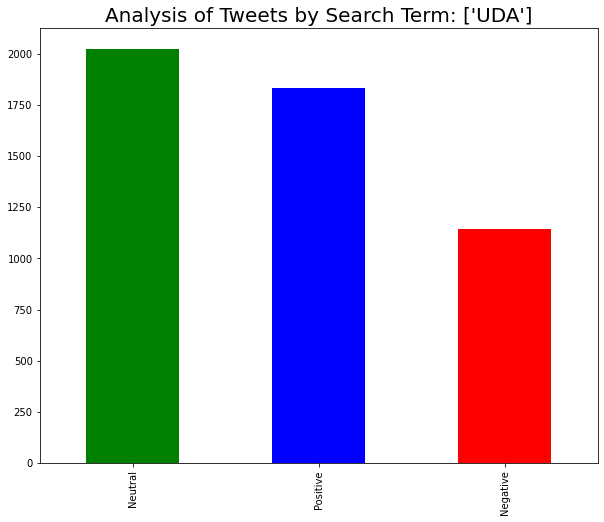

In [20]:
# Plotting the polarity of the tweets
ax1 = tweets_df['analysis'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'], figsize=(10, 8))
ax1.set_title(f'Analysis of Tweets by Search Term: {keywords}', fontsize=20)

Text(0.5, 1.0, "% of Positive, Negative and Neutral Tweets - ['UDA']")

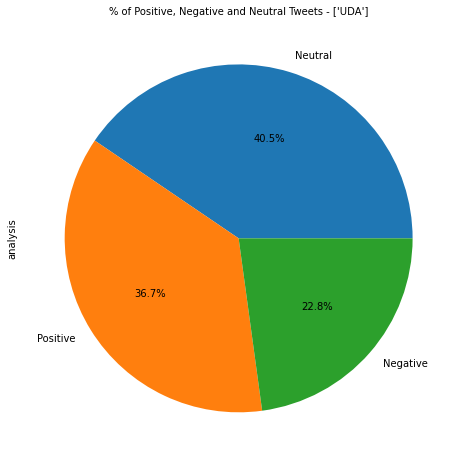

In [21]:
# Pie chart of the polarity of the tweets
ax3 = tweets_df['analysis'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 8))
ax3.set_title(f'% of Positive, Negative and Neutral Tweets - {keywords}', fontsize=10)

Text(0.5, 1.0, "% of Subjective Tweets - ['UDA']")

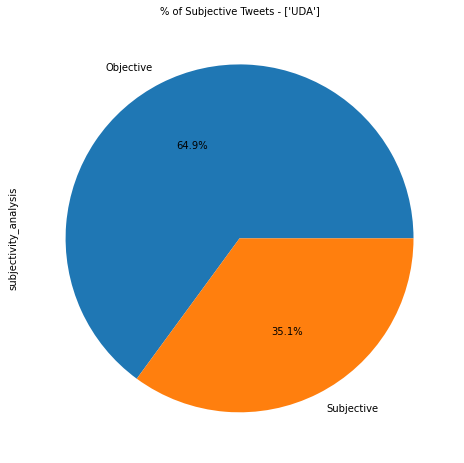

In [22]:
# Pie chart of the subjectivity of the tweets
ax3 = tweets_df['subjectivity_analysis'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 8))
ax3.set_title(f'% of Subjective Tweets - {keywords}', fontsize=10)

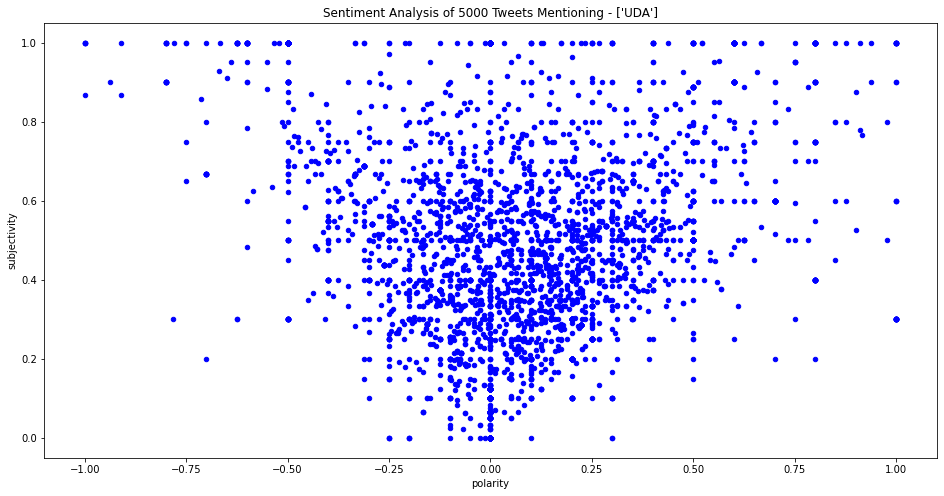

In [23]:
# Plot polarity and subjectivity of the tweets
ax4 = tweets_df.plot(kind='scatter', x='polarity', y='subjectivity', color='blue', figsize=(16,8))
ax4.title.set_text(f'Sentiment Analysis of 5000 Tweets Mentioning - {keywords}')